In [2]:
import pandas as pd
import numpy as np
from pydub import AudioSegment
import librosa

In [3]:
# path='../../data/train/asbfly/XC134896.ogg'
# path='../../data/train/ashwoo2/XC125152.ogg'
path='../../data/train/asiope1/XC194954.ogg'

In [4]:
audio = AudioSegment.from_ogg(path)

print(audio)
print(type(audio))

# audio duration
duration_seconds=len(audio)/1000.0

print(duration_seconds)
# print(duration_seconds/60) # minutes

# sampling rate
sr=audio.frame_rate

print(sr)

# the num of channels
print(audio.channels)

# bit depth
bit_depth=audio.sample_width * 8

print(bit_depth)

<class 'pydub.audio_segment.AudioSegment'>
14.289
32000
1
32


In [5]:
samples = np.array(audio.get_array_of_samples())

# If it is stereo (two-channel), it needs to be converted to mono
if audio.channels == 2:
    samples = samples.reshape((-1, 2)).mean(axis=1)

In [6]:
# calculate sampling rate
fs = audio.frame_rate

# Resample (optional, if downsampling is required)
samples = librosa.resample(y=samples.astype(float), orig_sr=fs, target_sr=48000)
# fs = 22050  # refresh sampling rate
fs=48000

# generate MFCC
mfcc_features = librosa.feature.mfcc(y=samples, sr=fs, n_mfcc=13, n_fft=2048, hop_length=512)


In [7]:
mfcc_features.shape

(13, 1340)

In [8]:
# normalization
mfcc_features = (mfcc_features - np.mean(mfcc_features, axis=0)) / np.std(mfcc_features, axis=0)


In [9]:
mfcc_features

array([[ 3.46410162,  3.4537202 ,  3.44745082, ...,  3.45194017,
         3.45618778,  3.46399624],
       [-0.28867513, -0.10722641, -0.02954021, ..., -0.07274916,
        -0.11370876, -0.27422962],
       [-0.28867513, -0.47062792, -0.51941926, ..., -0.47438493,
        -0.43744013, -0.30509533],
       ...,
       [-0.28867513, -0.27143076, -0.2742781 , ..., -0.28538259,
        -0.2754621 , -0.29168014],
       [-0.28867513, -0.24254624, -0.29266765, ..., -0.33187136,
        -0.32796287, -0.28873882],
       [-0.28867513, -0.26398423, -0.29369829, ..., -0.31154206,
        -0.30557674, -0.29283247]])

In [10]:
# Example: Ensuring that the MFCC feature matrix is ​​of fixed length
max_length = 500  # Assume the model requires a fixed length
if mfcc_features.shape[1] > max_length:
    mfcc_features = mfcc_features[:, :max_length]
else:
    mfcc_features = np.pad(mfcc_features, ((0, 0), (0, max_length - mfcc_features.shape[1])), mode='constant')


In [11]:
mfcc_features.shape

(13, 500)

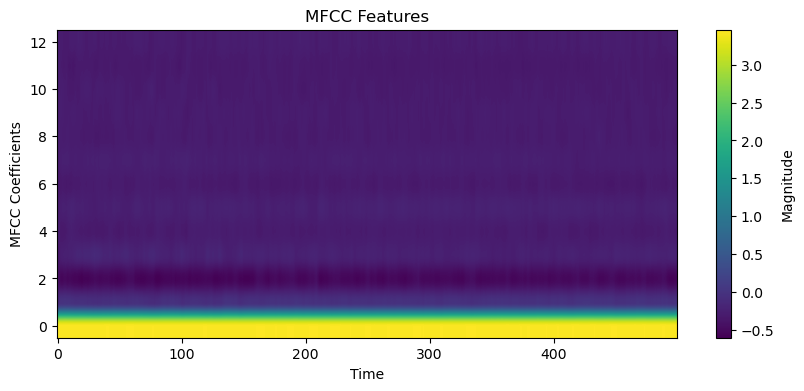

In [12]:
import matplotlib.pyplot as plt

# Draw MFCC feature map
plt.figure(figsize=(10, 4)) 
plt.imshow(mfcc_features, aspect='auto', origin='lower', cmap='viridis')  # cmap is set to 'viridis' for better visual effects
plt.title('MFCC Features')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.colorbar(label='Magnitude')
plt.show()


https://www.youtube.com/watch?v=WJI-17MNpdE

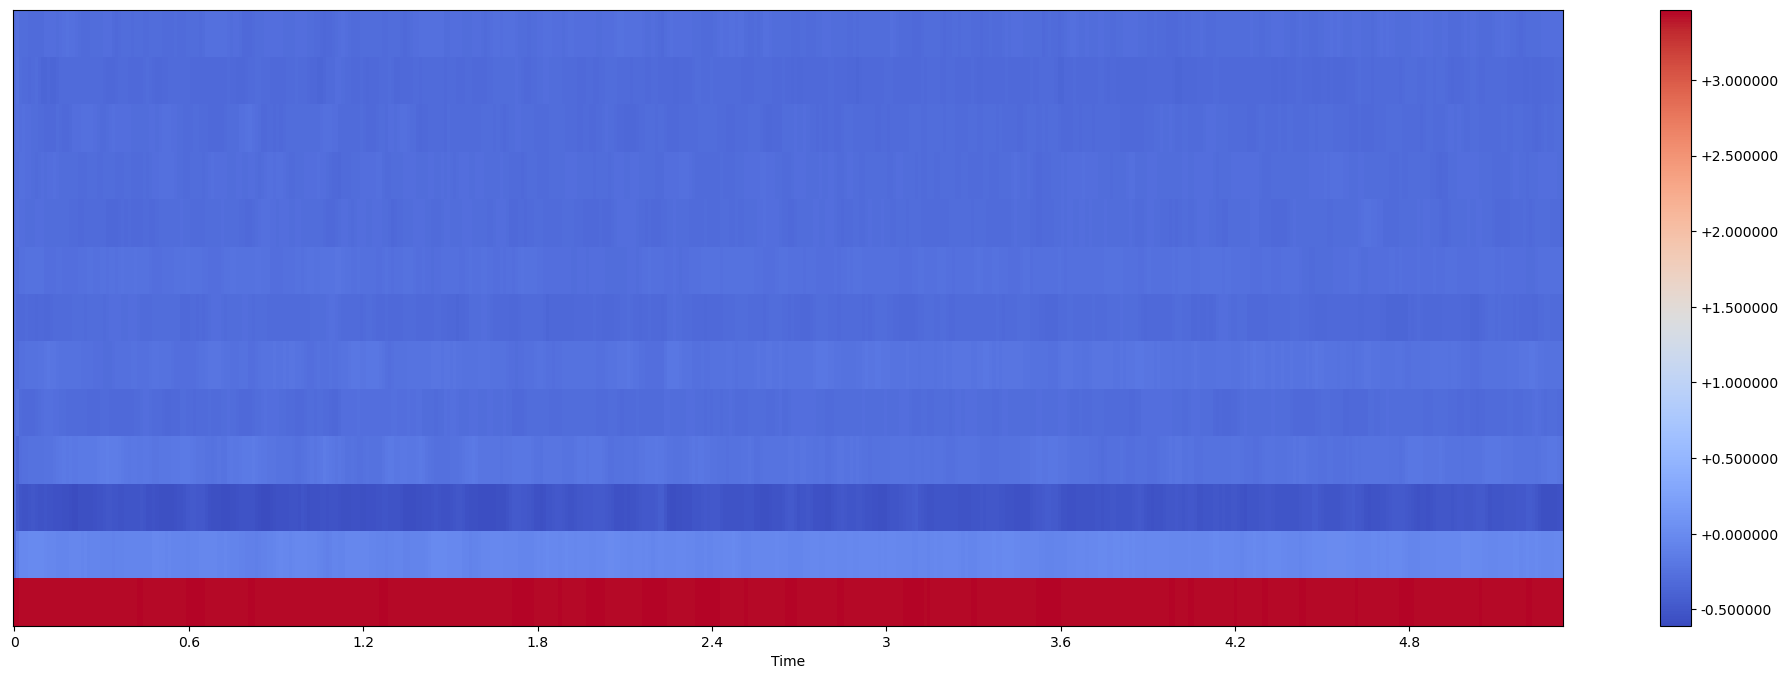

In [13]:
plt.figure(figsize=(25,8))
librosa.display.specshow(mfcc_features,x_axis='time',sr=fs)
plt.colorbar(format="%+2f")
plt.show()

## delta MFCC & delta-delta MFCC


Delta MFCC (Difference Mel-Frequency Cepstral Coefficients) is a feature derived from the original MFCC features to capture the rate of change or dynamic changes of MFCC features over time. Delta MFCC represents the first-order difference (i.e., time derivative) of the MFCC feature sequence, while the second-order difference, called Delta-Delta MFCC or acceleration coefficient, is sometimes calculated to capture the acceleration of MFCC changes.

Delta MFCC and Delta-Delta MFCC are often used as features together with the original MFCC to provide more comprehensive information about how the signal changes over time. These features are very important for audio processing tasks, especially when time dynamics are involved.

In [17]:
# calculate delta MFCC

delta_mfcc=librosa.feature.delta(mfcc_features)
delta2_mfcc=librosa.feature.delta(mfcc_features,order=2)

In [18]:
print(delta_mfcc.shape)
print(delta2_mfcc.shape)

(13, 500)
(13, 500)


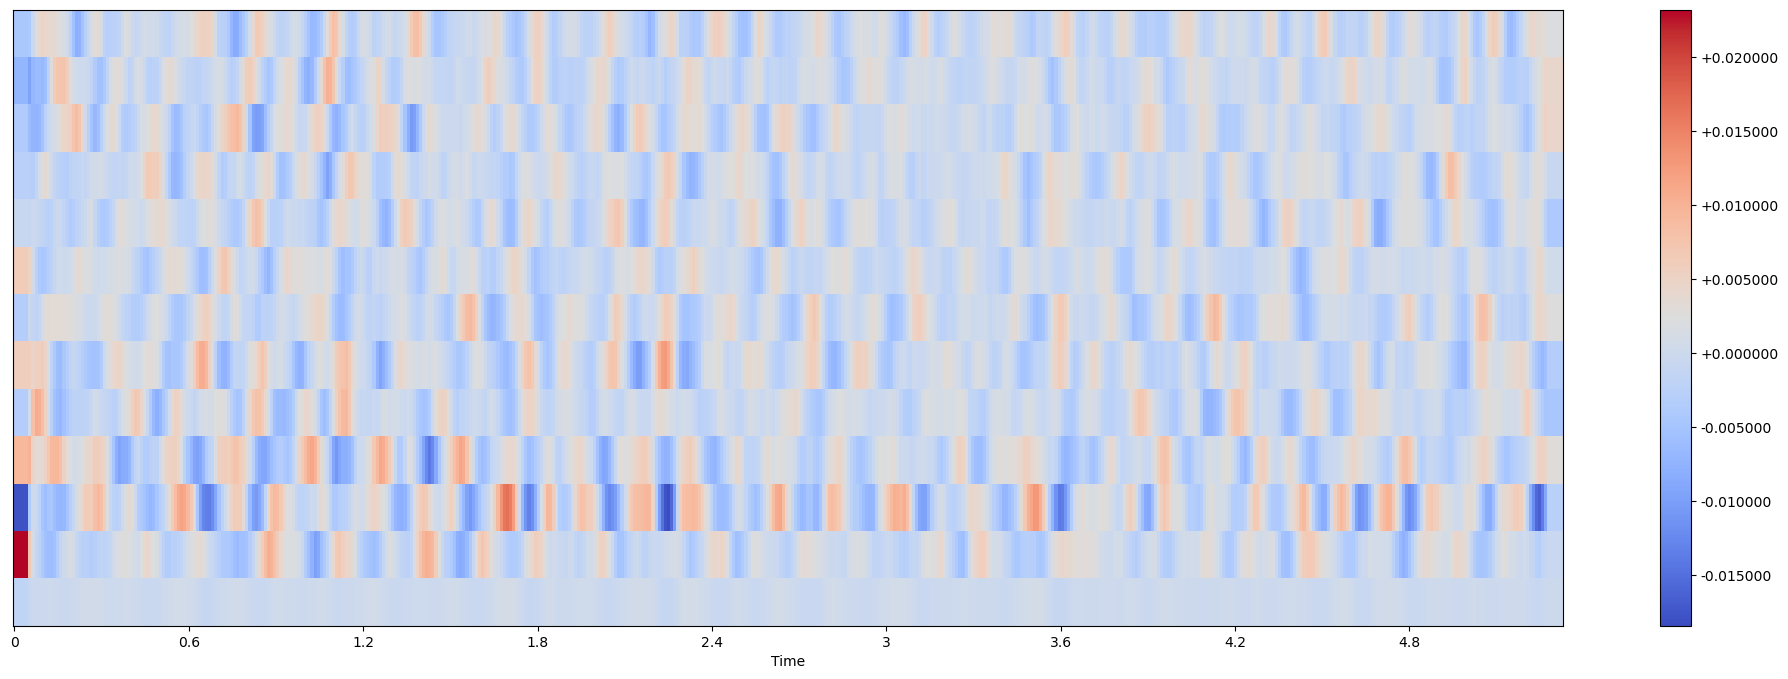

In [19]:
plt.figure(figsize=(25,8))
librosa.display.specshow(delta_mfcc,x_axis='time',sr=fs)
plt.colorbar(format="%+2f")
plt.show()

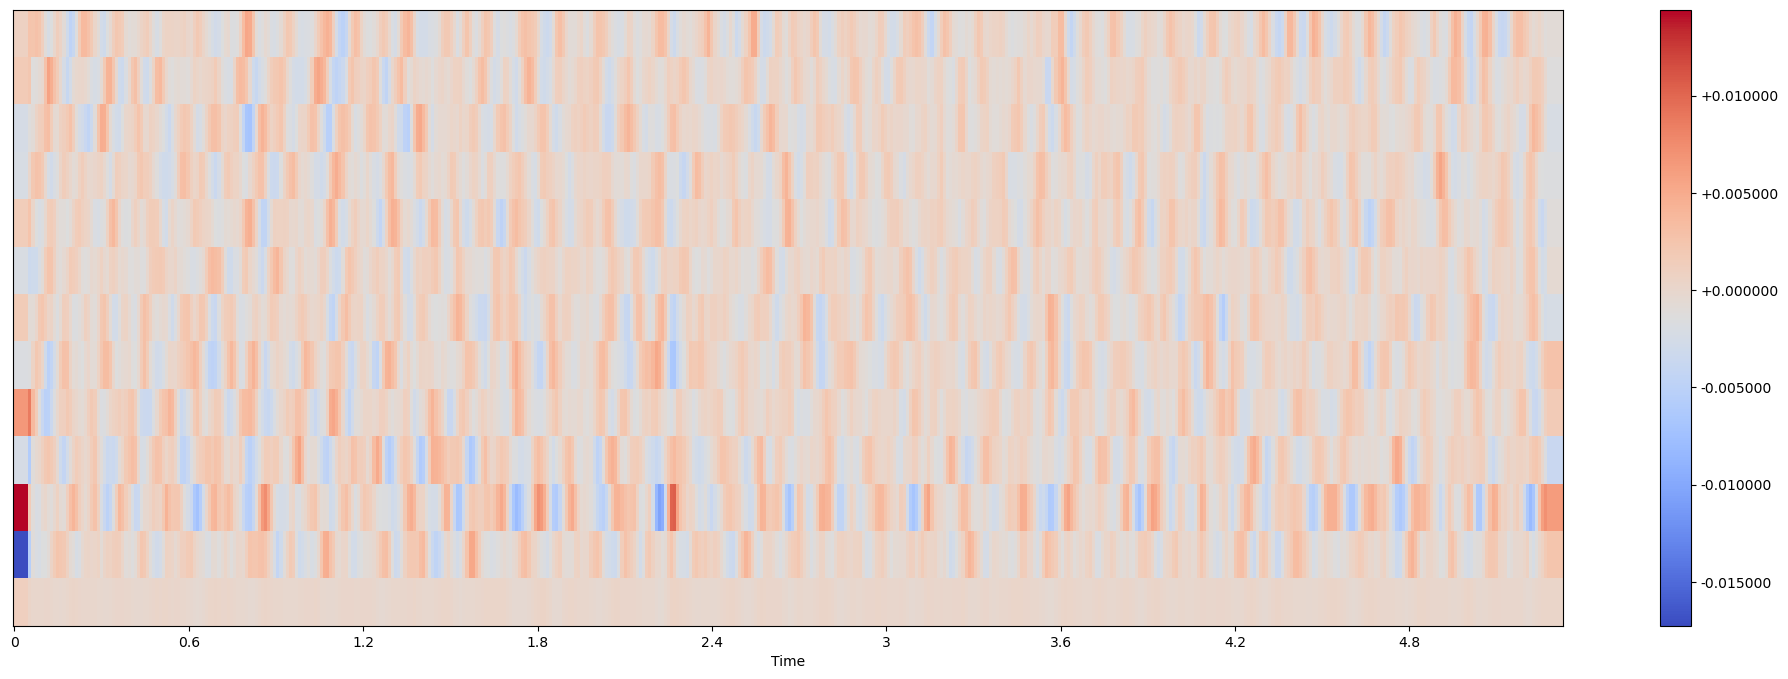

In [20]:
plt.figure(figsize=(25,8))
librosa.display.specshow(delta2_mfcc,x_axis='time',sr=fs)
plt.colorbar(format="%+2f")
plt.show()

## concatenate original mfcc, delta and delta2 together as a complete audio feature

In [22]:
comprehensive_mfccs=np.concatenate((mfcc_features,delta_mfcc,delta2_mfcc),axis=0)

In [23]:
comprehensive_mfccs.shape

(39, 500)

In [14]:
import librosa
import numpy as np

y, sr = librosa.load(path)

mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

print(mfcc)
print(mfcc.shape)

# calculate time domain info
rms = librosa.feature.rms(y=y)
print(rms)
print(rms.shape)
zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
print(zero_crossing_rate.shape)

# calculate frequency domain info
spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
print(spectral_centroid.shape)
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
spectral_flatness = librosa.feature.spectral_flatness(y=y)

# Combining feature vectors
features = np.concatenate((np.mean(mfcc, axis=1),
                           np.mean(rms, axis=1),
                           np.mean(zero_crossing_rate, axis=1),
                           np.mean(spectral_centroid, axis=1),
                           np.mean(spectral_bandwidth, axis=1),
                           np.mean(spectral_flatness, axis=1)), axis=0)

[[-349.0621     -196.33665    -156.0747     ... -186.37788
  -231.68579    -357.75488   ]
 [  41.676678     41.365326     48.821114   ...   27.065628
    36.84462      42.86419   ]
 [ -89.30748     -87.04906     -78.43456    ...  -76.42479
   -62.589462    -46.450573  ]
 ...
 [  -4.0622454    -0.68241274    1.5969193  ...    1.487463
     5.5341716     8.338806  ]
 [  12.881308     10.878162      6.8327456  ...   -4.2778587
    -3.6794848    -4.857135  ]
 [   8.564451     12.940718     11.0843115  ...    7.856698
     5.089447      5.7699804 ]]
(40, 616)
[[0.02197097 0.02724165 0.03831205 0.04772956 0.05629999 0.08405769
  0.09803017 0.10939673 0.11515424 0.11267933 0.11259163 0.10215485
  0.09178236 0.08217563 0.06707649 0.06262974 0.05893896 0.04138838
  0.03264968 0.03464468 0.04947242 0.07203797 0.08111563 0.0847838
  0.0785332  0.05798209 0.04123414 0.02914489 0.0384467  0.05142545
  0.05834617 0.06351859 0.06383436 0.07187707 0.07311077 0.08532818
  0.09831478 0.09992021 0.098409

In [15]:
features.shape

(45,)

In [17]:
np.mean(mfcc, axis=1).shape

(40,)